In [262]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
#python -m spacy download en_core_web_sm
#python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
from sklearn.datasets import fetch_20newsgroups

import pickle
import bz2
import time
import logging
import os



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [311]:
#Bug fix for pyLDAvis https://github.com/bmabey/pyLDAvis/issues/162
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

# Load datapickle 
From wikidownloader.py

In [264]:
print('Load data pickle')
with bz2.BZ2File('datapicklesoup.bz2', 'rb') as f:  #Use datacompression BZ2
    data= pickle.load(f)
print('Loaded data pickle')
    
df=pd.DataFrame({'text':data[0],'title':data[1]})

Load data pickle
Loaded data pickle


In [265]:
df

,text,title
0,Megacraspedus cuencellus is a moth of the fami...,Megacraspedus_cuencellus
1,Jellyfish dermatitis is a cutaneous condition ...,Jellyfish_dermatitis
2,The Hadrianic Society was a British historical...,Hadrianic_Society
3,The CPL–U Sports Draft (French: Repêchage de l...,CPL%E2%80%93U_Sports_Draft
4,Mikhail Ivanovich Meltyukhov (Russian: Russian...,Mikhail_Meltyukhov
...,...,...
49884,Swertia perennis is a species of flowering pla...,Swertia_perennis
49885,Sarah Johns (born 1979) is an American country...,Sarah_Johns
49886,Abū Thābit Sulaymān ibn Saʿd al-Khūshani (Arab...,Sulayman_ibn_Sa%27d_al-Khushani
49887,Argyresthia pilatella is a moth of the family ...,Argyresthia_pilatella


In [273]:
#remove zero length articles
articlelen=df.text.apply(len)
df=df[articlelen>10]

# Tokenizing articles


In [274]:
def sent_to_words(sentences):
   for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data_words = list(sent_to_words(df.text))

In [275]:
print(df.text[0][:400])

Megacraspedus cuencellus is a moth of the family Gelechiidae. It was described by Aristide Caradja in 1920. It is found in France and Spain. The forewings are uniform mouse grey with the margin whitish from one-third to the apex. The hindwings are mouse grey. 


In [276]:
print(data_words[0][:40])

['megacraspedus', 'cuencellus', 'is', 'moth', 'of', 'the', 'family', 'gelechiidae', 'it', 'was', 'described', 'by', 'aristide', 'caradja', 'in', 'it', 'is', 'found', 'in', 'france', 'and', 'spain', 'the', 'forewings', 'are', 'uniform', 'mouse', 'grey', 'with', 'the', 'margin', 'whitish', 'from', 'one', 'third', 'to', 'the', 'apex', 'the', 'hindwings']


In [277]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print([(id2word[id], freq) for id, freq in corpus[0]][:20])
print(corpus[0][:20]) #it will print the corpus we created above.



[('and', 1), ('apex', 1), ('are', 2), ('aristide', 1), ('by', 1), ('caradja', 1), ('cuencellus', 1), ('described', 1), ('family', 1), ('forewings', 1), ('found', 1), ('france', 1), ('from', 1), ('gelechiidae', 1), ('grey', 2), ('hindwings', 1), ('in', 2), ('is', 2), ('it', 2), ('margin', 1)]
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 2), (17, 2), (18, 2), (19, 1)]


# Removing stop words and adding bigrams

In [278]:

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc)) 
   if word not in stop_words] for doc in texts]
def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)


In [279]:
print(data_words_nostops[0][:40])

['megacraspedus', 'cuencellus', 'moth', 'family', 'gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


In [280]:
print(data_words_bigrams[0][:40])

['megacraspedus', 'cuencellus', 'moth', 'family_gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


# Lemmatization

Reference: https://www.researchgate.net/publication/341574872_Machine_Learning_and_Deep_Neural_Network-Based_Lemmatization_and_Morphosyntactic_Tagging_for_Serbian


The basic set of PoS-categories/tags that should be as-signed to tokens is not generally accepted, even for a speciﬁc language. The choice of a tagset usually depends on the foreseen task or project. A tagset tailored to be applicable for PoS-tagging in general is the Universal Part-of-Speech (UPoS) tagset (Petrov et al., 2012) (used by spaCy), and it lists the following 17 categories: adjective(ADJ), adposition (ADP), adverb (ADV), auxiliary (AUX),coordinating conjunction (CCONJ), determiner (DET), interjection (INTJ), noun (N), numerical (NUM), particle(PART), pronoun (PRON), proper noun (PROPN), punctuation (PUNCT), subordinating conjunction (SCONJ), symbol (SYM), verb (VERB) and other (X). It should be notedthat the MULTEXT-East tagset (Erjavec, 2012) was alsotailored to be universal. SMD uses its own tagset thatcorresponds closely to Serbian traditional grammars. TheSerbian TreeTagger models TT11 and TT19 (see Subsec-tion 3.3.) use modiﬁcations of the SMD tagset. A gen-eral overview of the tagsets used is presented in Table 3.It should be noted that tags for some PoS differ betweentagsets (e.g. ADJ in UPoS vs. A in SMD for adjective

In [281]:
doc=nlp(" ".join(data_words_bigrams[0]))

In [282]:
tags=[]
for w in doc:
    if not w.pos_ in tags:
        print('Lemmatization Example {} -> {}'.format(w.lemma_,w.pos_))
        tags.append(w.pos_)
tags

Lemmatization Example megacraspedus -> PROPN
Lemmatization Example moth -> NOUN
Lemmatization Example describe -> VERB
Lemmatization Example whitish -> ADJ
Lemmatization Example one -> NUM


['PROPN', 'NOUN', 'VERB', 'ADJ', 'NUM']

We will only keep the UPoS with the following tags 'NOUN', 'ADJ', 'VERB', 'ADV'

In [283]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

def lemmatization2(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
      doc = nlp(sent)
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out


In [284]:
#bigrams, then lemmatize, then remove stop words
data_lemmatized = make_bigrams(data_words)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_lemmatized, allowed_postags=[
   'NOUN', 'ADJ', 'VERB', 'ADV'
])
data_lemmatized = remove_stopwords(data_lemmatized)


In [285]:
print(data_lemmatized[0][:40]) #it will print the lemmatized data.

['describe', 'find', 'forewing', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'third', 'apex', 'hindwing', 'mouse', 'grey']


In [286]:
print(data_words_bigrams[0][:55])

['megacraspedus', 'cuencellus', 'moth', 'family_gelechiidae', 'described', 'aristide', 'caradja', 'found', 'france', 'spain', 'forewings', 'uniform', 'mouse', 'grey', 'margin', 'whitish', 'one', 'third', 'apex', 'hindwings', 'mouse', 'grey']


# Creating bag of words frequencies

Without Lemmatization

In [287]:
id2word = corpora.Dictionary(data_words_bigrams)
texts = data_words_bigrams
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0][:20]) #it will print the corpus we created above.
[(id2word[id], freq) for id, freq in corpus[0]][:20]
#it will print the words with their frequencies.


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)]


[('apex', 1),
 ('aristide', 1),
 ('caradja', 1),
 ('cuencellus', 1),
 ('described', 1),
 ('family_gelechiidae', 1),
 ('forewings', 1),
 ('found', 1),
 ('france', 1),
 ('grey', 2),
 ('hindwings', 1),
 ('margin', 1),
 ('megacraspedus', 1),
 ('moth', 1),
 ('mouse', 2),
 ('one', 1),
 ('spain', 1),
 ('third', 1),
 ('uniform', 1),
 ('whitish', 1)]

In [288]:
print(f'Number of unique tokens: {len(id2word)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 380536
Number of documents: 49835


With Lemmatization

In [289]:
id2word_lemmatized = corpora.Dictionary(data_lemmatized)

# Filter out words that occur less than X documents, 
# or more than X% of the documents.
id2word_lemmatized.filter_extremes(no_below=10, no_above=0.1)

corpus_lemmatized = [id2word_lemmatized.doc2bow(text) for text in data_lemmatized]
print(corpus_lemmatized[0][:20]) #it will print the corpus we created above.
[(id2word_lemmatized[id], freq) for id, freq in corpus_lemmatized[0]][:20]
#it will print the words with their frequencies.


[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1)]


[('apex', 1),
 ('describe', 1),
 ('forewing', 1),
 ('grey', 2),
 ('hindwing', 1),
 ('margin', 1),
 ('mouse', 2),
 ('third', 1),
 ('uniform', 1),
 ('whitish', 1)]

In [290]:
print(f'Number of unique tokens: {len(id2word_lemmatized)}')
print(f'Number of documents: {len(corpus_lemmatized)}')

Number of unique tokens: 26262
Number of documents: 49835


In [291]:
dictwords=set(id2word_lemmatized.values())

In [292]:
data_lemmatized_filtered=[[w for w in article if w in dictwords] for article in data_lemmatized]

# Fitting via LDA Variational Inference (Gensim) library

About Gensim algorithmn

The core estimation code is based on the `onlineldavb.py script

    https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py
    Matthew D. Hoffman, David M. Blei, Francis Bach:
    
Online Learning for Latent Dirichlet Allocation', NIPS 2010

    Hoffman et al.: online-lda_
    https://papers.neurips.cc/paper/2010/file/71f6278d140af599e06ad9bf1ba03cb0-Paper.pdf


![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA.PNG?raw=true)

![LDA ALGO](https://github.com/duha-aldebakel/DSC180B-LDACode/blob/master/images/VB_LDA_Algo1.PNG?raw=true)

EM Algorihmn explanation:

Given the statistical model which generates a set w  of observed data (corpus), a set of unobserved latent data beta and theta, and a vector of unknown parameters lambda, along with a likelihood function

    First, initialize the parameters lambda to some random values.
    E: Compute the probability of each possible value of beta and theta, given lambda λ
    M: Use the just-computed probability disribution of beta and theta to compute a better estimate for the parameters lambda
    Iterate E-step 2 and M-step 3 until convergence.

E step: 

    fits phi φ(per word topic assignment) and gamma γ (topic assignment for document k)
    note phi φ is the associated variational parameter of z

    for every document
      hillclimb until peak
        phi φ (per word topic assignment) 
        word w in document d is likely part of topic k if 
          theta, the topic distribution for that document d is high for k
          plus
          beta, the word w is often associated with topic k
        gamma γ (topic assignment for document k)
          has its distribution by taking into account 
          phi (per word topic assignment)  times n
          n is the frequency word w appears in document d. 
      
M step:

    fits lambda λ, the distribution of words across topics
    (lambda λ is the associated variational parameter to beta)



Set up logging

In [293]:

def setUpNewLogFile(LOG_FILENAME):

    #logging.basicConfig(filename=LOG_FILENAME,
    #                    format="%(asctime)s:%(levelname)s:%(message)s",
    #                    level=logging.INFO)

    my_logger = logging.getLogger()
    my_logger.setLevel(logging.INFO)
    my_logger.handlers.clear()
    handlers = my_logger.handlers[:]
    for handler in handlers:
        handler.close()
        my_logger.removeHandler(handler)

    # Check if log exists and should therefore be rolled
    needRoll = os.path.isfile(LOG_FILENAME)

    # Add the log message handler to the logger
    handler = logging.handlers.RotatingFileHandler(LOG_FILENAME, backupCount=50)

    my_logger.addHandler(handler)

    # This is a stale log, so roll it
    if needRoll:    
        # Add timestamp
        my_logger.debug('\n---------\nLog closed on %s.\n---------\n' % time.asctime())

        # Roll over on application start
        my_logger.handlers[0].doRollover()
    

## Without Lemmatization

In [294]:
starttime=time.time()
setUpNewLogFile('gensim_nolem.log')

#Old code
#lda_model = gensim.models.ldamodel.LdaModel(

#New code uses multicore which runs works in parallel for each CPU core.
lda_model = gensim.models.ldamulticore.LdaMulticore(
   corpus=corpus, id2word=id2word, num_topics=20, random_state=100, 
   eval_every=1000, chunksize=200, passes=20, alpha='symmetric', per_word_topics=True
)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

Time taken = 23 minutes


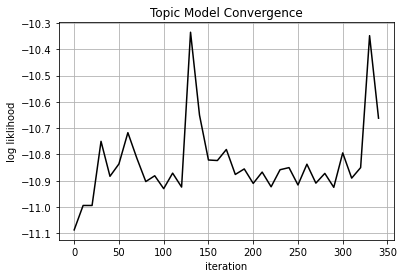

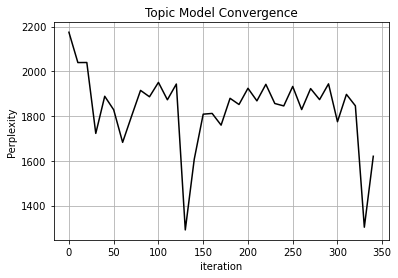

Note: Perplexity estimate based on a held-out corpus of 4 documents


In [295]:

p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim_nolem.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter[:-1],liklihood[:-1],c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()


plt.plot(iter[:-1],perplexity[:-1],c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()
print('Note: Perplexity estimate based on a held-out corpus of 4 documents')


In [296]:
print('\nLog Likelihood(per-word ELBO): ', lda_model.log_perplexity(corpus))


Log Likelihood(per-word ELBO):  -11.251620189211945


In [297]:
coherence_model_lda = CoherenceModel(
   model=lda_model, texts=texts, dictionary=id2word, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5571094875357259


## With Lemmatization and dictionary compression

In [298]:
starttime=time.time()
setUpNewLogFile('gensim_lem.log')

#Old code
#lda_model_lemmatized = gensim.models.ldamodel.LdaModel(

#New code uses multicore which runs works in parallel for each CPU core.
lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
   corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=20, random_state=100, 
   eval_every=1000, chunksize=1000, passes=10, alpha='symmetric', per_word_topics=True
)
print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))

Time taken = 3 minutes


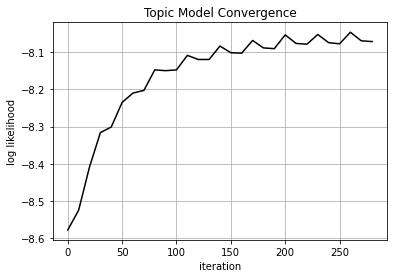

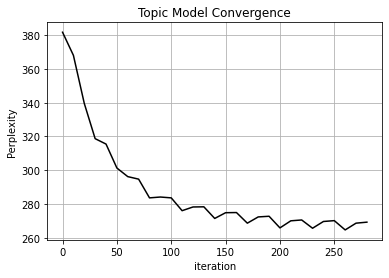

Note: Log likelihood is per-word ELBO
Note: Perplexity estimate based on a held-out corpus of 4 documents


In [299]:
p = re.compile(r"(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
matches = [p.findall(l) for l in open('gensim_lem.log')]
matches = [m for m in matches if len(m) > 0]
tuples = [t[0] for t in matches]
perplexity = [float(t[1]) for t in tuples]
liklihood = [float(t[0]) for t in tuples]
iter = list(range(0,len(tuples)*10,10))
plt.plot(iter[:-1],liklihood[:-1],c="black")
plt.ylabel("log likelihood")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()


plt.plot(iter[:-1],perplexity[:-1],c="black")
plt.ylabel("Perplexity")
plt.xlabel("iteration")
plt.title("Topic Model Convergence")
plt.grid()
plt.show()
print('Note: Log likelihood is per-word ELBO')
print('Note: Perplexity estimate based on a held-out corpus of 4 documents')


In [300]:
print('\nLog Likelihood(per-word ELBO): ', lda_model_lemmatized.log_perplexity(corpus_lemmatized))



Log Likelihood(per-word ELBO):  -8.056373744136673


In [301]:
coherence_model_lda_lemmatized = CoherenceModel(
   model=lda_model_lemmatized, texts=data_lemmatized_filtered, dictionary=id2word_lemmatized, coherence='c_v'
)
coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
print('\nCoherence Score: ', coherence_lda_lemmatized)




Coherence Score:  0.6382933600408686


# About how gensim reports perplexity
https://tedboy.github.io/nlps/_modules/gensim/models/ldamodel.html#LdaModel.log_perplexity

    They calculate the ELBO of the variational inferred q vs p in function "bound"
    
        def bound(self, corpus, gamma=None, subsample_ratio=1.0):
            Estimate the variational bound of documents from `corpus`:
            E_q[log p(corpus)] - E_q[log q(corpus)]
        
    Then they divide the ELBO by the number of words/tokens so that it is "per-word".
    The likelihood reported above is the per-word likelihood, and perplexity=2^(-bound)
        
        def log_perplexity(self, chunk, total_docs=None):
            Calculate and return per-word likelihood bound, using the `chunk` of
            documents as evaluation corpus. Also output the calculated statistics. incl.
            perplexity=2^(-bound), to log at INFO level.


## Finding the right value of K

In [302]:
K_Coherence={}
models={}

In [303]:

for K in [5,10,15,20,25,30,40]:
    print('Starting K={}'.format(K))
    starttime=time.time()
    setUpNewLogFile('gensim_lem_{}.log'.format(K))

    #New code uses multicore which runs works in parallel for each CPU core.
    lda_model_lemmatized = gensim.models.ldamulticore.LdaMulticore(
       corpus=corpus_lemmatized, id2word=id2word_lemmatized, num_topics=K, random_state=100, 
       eval_every=1000, chunksize=1000, passes=8, alpha='symmetric', per_word_topics=True
    )
    coherence_model_lda_lemmatized = CoherenceModel(
       model=lda_model_lemmatized, texts=data_lemmatized_filtered, dictionary=id2word_lemmatized, coherence='c_v'
    )
    coherence_lda_lemmatized = coherence_model_lda_lemmatized.get_coherence()
    print('Coherence Score: ', coherence_lda_lemmatized)
    K_Coherence[K]=coherence_lda_lemmatized
    print('Time taken = {:.0f} minutes'.format((time.time()-starttime)/60.0))
    models[K]=lda_model_lemmatized

Starting K=5
Coherence Score:  0.5389239567891656
Time taken = 3 minutes
Starting K=10
Coherence Score:  0.6099184296764066
Time taken = 3 minutes
Starting K=15
Coherence Score:  0.5995024409502642
Time taken = 4 minutes
Starting K=20
Coherence Score:  0.6394890159926446
Time taken = 4 minutes
Starting K=25
Coherence Score:  0.6345741806955959
Time taken = 5 minutes
Starting K=30
Coherence Score:  0.604773339929556
Time taken = 5 minutes
Starting K=40
Coherence Score:  0.588151741777159
Time taken = 5 minutes


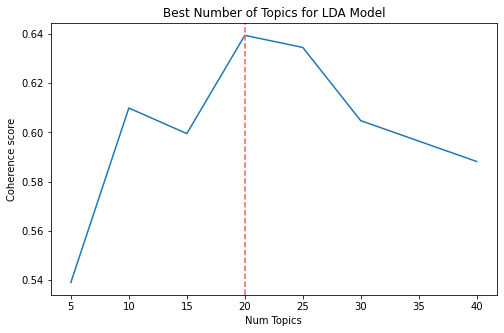

In [304]:
plt.figure(figsize=(8,5))

x = list(K_Coherence.keys())
coherence_values= list(K_Coherence.values())

# Build the line plot
#ax = sns.lineplot(x=x, y=coherence_values, color='#238C8C')
ax=plt.plot(x,coherence_values)

# Set titles and labels
plt.title("Best Number of Topics for LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")

# Add a vertical line to show the optimum number of topics
plt.axvline(x[np.argmax(coherence_values)], 
            color='#F26457', linestyle='--')


# Exploring final model (with Lemmatization)

In [308]:
#Choose model with K=20
lda_model_lemmatized=models[20]

In [309]:
pprint(lda_model_lemmatized.print_topics())

[(0,
  '0.007*"displaystyle" + 0.006*"example" + 0.005*"cell" + 0.005*"function" + '
  '0.005*"language" + 0.004*"case" + 0.004*"term" + 0.004*"protein" + '
  '0.004*"result" + 0.004*"type"'),
 (1,
  '0.060*"film" + 0.011*"star" + 0.009*"series" + 0.008*"direct" + '
  '0.007*"character" + 0.006*"movie" + 0.005*"role" + 0.005*"award" + '
  '0.005*"kill" + 0.005*"production"'),
 (2,
  '0.027*"club" + 0.024*"season" + 0.017*"league" + 0.016*"match" + '
  '0.015*"championship" + 0.014*"final" + 0.013*"football" + 0.012*"game" + '
  '0.011*"player" + 0.010*"event"'),
 (3,
  '0.010*"design" + 0.009*"system" + 0.006*"engine" + 0.006*"power" + '
  '0.006*"model" + 0.006*"car" + 0.005*"produce" + 0.005*"vehicle" + '
  '0.004*"low" + 0.004*"production"'),
 (4,
  '0.025*"station" + 0.024*"line" + 0.023*"road" + 0.016*"route" + '
  '0.014*"railway" + 0.012*"north" + 0.010*"highway" + 0.010*"bridge" + '
  '0.010*"train" + 0.010*"county"'),
 (5,
  '0.028*"woman" + 0.017*"medical" + 0.017*"hospital" 

In [310]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_lemmatized, corpus_lemmatized, id2word_lemmatized)
vis

C:\Users\jorda\anaconda3\envs\WH\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.006728 -0.115963       1        1  9.481036
14    -0.026471  0.187847       2        1  6.770130
19    -0.028157  0.094460       3        1  5.984830
8      0.070910 -0.082267       4        1  5.918457
10    -0.032885 -0.073111       5        1  5.810189
0     -0.171757  0.072211       6        1  5.624920
18    -0.042914 -0.088352       7        1  5.511085
17    -0.175077 -0.030572       8        1  5.497280
2      0.254954 -0.074109       9        1  5.341309
7     -0.054756 -0.149559      10        1  5.283912
3     -0.062755  0.162945      11        1  5.276440
1      0.046075 -0.068103      12        1  4.846018
13    -0.036611 -0.062209      13        1  4.792840
12    -0.083326 -0.071083      14        1  4.635455
16     0.078912  0.080530      15        1  3.649041
15     0.248828 -0.051203      16        1  3.615617
11     0.004560  0.016546      17        1  3.524443
4      0.063753  0.203928      18        1  3.443402
6      0.068982  0.153213      19        1  2.756727
5     -0.115538 -0.105147      20        1  2.236868, topic_info=          Term          Freq         Total Category  logprob  loglift
993       film  21070.000000  21070.000000  Default  30.0000  30.0000
124     season  18952.000000  18952.000000  Default  29.0000  29.0000
621       game  19000.000000  19000.000000  Default  28.0000  28.0000
1512     album  11981.000000  11981.000000  Default  27.0000  27.0000
535       song  11597.000000  11597.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
798     center    501.151378   5968.043515  Topic20  -5.6885   1.3228
1884    mother    433.424876   4269.423383  Topic20  -5.8337   1.5126
1433      help    448.443930   6888.168037  Topic20  -5.7996   1.0683
10       cause    432.418258   5848.730622  Topic20  -5.8360   1.1955
1582  training    416.418579   3365.300198  Topic20  -5.8737   1.7105

[1746 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
16119     17  0.978127  abc_affiliate
10866      5  0.977381       abdicate
19985      5  0.956248     abdication
4516       1  0.056672       abortion
4516       4  0.002576       abortion
...      ...       ...            ...
9900      13  0.985172        zionist
11817      1  0.028955         zombie
11817      4  0.062735         zombie
11817     12  0.883122         zombie
11817     17  0.024129         zombie

[13094 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 15, 20, 9, 11, 1, 19, 18, 3, 8, 4, 2, 14, 13, 17, 16, 12, 5, 7, 6])